# Predictive Modeling in Ed
- *Author*: Jai Miles
- *Date*: 12/12/2002
- *Purpose*: This notebook uses Random Forest to create a predictive model for student GPA
- *Data*: [Student Alcohol Consumption](https://www.kaggle.com/uciml/student-alcohol-consumption?select=student-por.csv)

This dataset 

*Data Citation*:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

## Imports

Need to add venv to kernel
```python -m ipykernel install --user --name=<my_env_name>```
[Using venv with jupyter nb kernel](https://towardsdatascience.com/create-virtual-environment-using-virtualenv-and-add-it-to-jupyter-notebook-6e1bf4e03415)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

import missingno as msno
import pywrangle as pw

# Data

UCI sampled two separate secondary school courses: (1) Mathematics, and (2) Portuguese. This analysis merges both datasets.

## Load data

In [2]:
data_math_course = "data/student-mat.csv"
data_port_course = "data/student-por.csv"

df_math = pd.read_csv(data_math_course)
df_port = pd.read_csv(data_port_course)

In [3]:
df_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
df_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Merge data

In [5]:
course_dfs = (df_math, df_port)
df_data = pd.concat(course_dfs)
df_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
pw.print_df_info(df_math, df_port, df_data)


Name       |   Cols   |      Rows   |      Size
--------   |   ----   |   -------   |   -------
0          |     33   |       395   |     13035
1          |     33   |       649   |     21417
2          |     33   |      1044   |     34452
Abs Diff   |      0   |       649   |     21417
% Diff     |    0.0   |   164.304   |   164.304

Compared indices -1 & 0


Shows that dataframes at indices 0 & 1 were appropriately concatenated into the dataframe at index 2 (df_grades)

# Categorical vars

We need to change string variables to numbers in order to include them in our model>

In [7]:
cat_cols = [c for c in df_data.columns if df_data[c].dtype == 'object']
print(cat_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [8]:
def is_female(x) -> int:
    """Returns integer if participant is female."""
    if x == 'f':
        return 1
    return 0
df_data['female'] = df_data.sex.apply(is_female)

In [9]:
def has_internet(x) -> int:
    """Returns integer if participant has internet."""
    if x == 'yes':
        return 1
    return 0

df_data['has_internet'] = df_data.internet.apply(has_internet)

In [10]:
def seek_higher_ed(x) -> int:
    """Returns int if participant is seeking higher education."""
    if x == 'yes':
        return 1
    return 0

df_data['seek_higher_ed'] = df_data.higher.apply(seek_higher_ed)

# Data for Modeling

Note that it is convention to name the data for the predictor variable `y` and the data for the features variables `X`.

In [11]:
y = df_data.G3

cat_features = [
    'female',
    'seek_higher_ed',
    'has_internet'
]
num_features = [
    "G2",
    "G1",
    "Medu",
    "Fedu",
    "studytime",
    "absences",
    "traveltime",
    "Walc",
    "Dalc",
    "failures"
]
features = cat_features + num_features

# features = ['female', 'seek_higher_ed']  # for visualization

In [12]:
X = df_data[features]

In [13]:
X.describe()

,female,seek_higher_ed,has_internet,G2,G1,Medu,Fedu,studytime,absences,traveltime,Walc,Dalc,failures
count,1044.0,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,0.0,0.914751,0.792146,11.246169,11.213602,2.603448,2.387931,1.970307,4.434866,1.522989,2.284483,1.494253,0.264368
std,0.0,0.279386,0.405967,3.285071,2.983394,1.124907,1.099938,0.834353,6.210017,0.731727,1.285105,0.911714,0.656142
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.0,1.000000,1.000000,9.000000,9.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,0.0,1.000000,1.000000,11.000000,11.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000
75%,0.0,1.000000,1.000000,13.000000,13.000000,4.000000,3.000000,2.000000,6.000000,2.000000,3.000000,2.000000,0.000000
max,0.0,1.000000,1.000000,19.000000,19.000000,4.000000,4.000000,4.000000,75.000000,4.000000,5.000000,5.000000,3.000000


# Train & Test datasets

In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [15]:
grade_model = DecisionTreeRegressor(random_state = 0)
grade_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=0)

In [16]:
val_X.head()

,female,seek_higher_ed,has_internet,G2,G1,Medu,Fedu,studytime,absences,traveltime,Walc,Dalc,failures
247,0,0,1,8,6,3,1,1,16,1,5,5,3
619,0,1,1,12,13,3,3,2,6,2,3,1,0
371,0,1,1,10,10,2,2,1,2,1,4,2,0
497,0,1,0,11,10,3,3,4,0,2,4,3,1
97,0,1,0,9,8,2,1,2,2,1,1,1,0


In [17]:
grade_model.predict(val_X.head())

array([ 5., 12., 10., 12.,  8.])

In [18]:
print(val_y.head())

247     8
619    13
371    10
497    10
97     10
Name: G3, dtype: int64


# Find best fit

In [19]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y) -> float:
    """Returns Mean Average Error for Decision Tree with maximum leaf nodes."""
    model = DecisionTreeRegressor(max_leaf_nodes= max_leaf_nodes, random_state = 0)
    model.fit(train_X, train_y)
    pred_vals = model.predict(val_X)
    mae = mean_absolute_error(val_y, pred_vals)
    return mae

In [20]:
def exponents_of_5(i = 1) -> int:
    while i <= 5:
        yield 5 ** i
        i += 1
    return

leaf_nodes = exponents_of_5()

for node in leaf_nodes:
    mae = get_mae(node, train_X, val_X, train_y, val_y)
    print(f"{node} nodes - {mae} mae")


5 nodes - 1.1425682536012502 mae
25 nodes - 0.8517791718457011 mae
125 nodes - 0.9488255697635377 mae
625 nodes - 1.0517241379310345 mae
3125 nodes - 1.0517241379310345 mae


Because the optimum unumber of leaf nodes here is so small (under 125), I will manually test small increments to find the ideal number of nodes.

In [21]:
min_mae = float('inf')
best_node = None

for node in range(5, 125, 5):
    mae = get_mae(node, train_X, val_X, train_y, val_y)
    print(f"{node} nodes - {mae} mae")
    if mae < min_mae:
        min_mae = mae
        best_node = node
        

print(f"Best fit node: {best_node}")

5 nodes - 1.1425682536012502 mae
10 nodes - 0.8752813252108199 mae
15 nodes - 0.8875785694046157 mae
20 nodes - 0.9125785694046157 mae
25 nodes - 0.8517791718457011 mae
30 nodes - 0.8548990404828112 mae
35 nodes - 0.8630216848225767 mae
40 nodes - 0.8639216429871609 mae
45 nodes - 0.8623087375201655 mae
50 nodes - 0.8585876907761896 mae
55 nodes - 0.8672722373917707 mae
60 nodes - 0.8784360886645148 mae
65 nodes - 0.8751040321857426 mae
70 nodes - 0.8824475826327414 mae
75 nodes - 0.8959289604072048 mae
80 nodes - 0.9143119822385025 mae
85 nodes - 0.9178842796688684 mae
90 nodes - 0.9226988334756703 mae
95 nodes - 0.9364964657863866 mae
100 nodes - 0.9388838130779482 mae
105 nodes - 0.9414230663271407 mae
110 nodes - 0.9494562373357345 mae
115 nodes - 0.9475067847116192 mae
120 nodes - 0.9462240927242795 mae
Best fit node: 25


# Model

In [22]:
grade_model = DecisionTreeRegressor(max_leaf_nodes= 25, random_state = 0)
grade_model.fit(train_X, train_y)

val_predictions = grade_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

0.8517791718457011


# Feature importance

In [23]:
importance = grade_model.feature_importances_
feature_importance = []

for i in range(len(features)):
    feature_importance.append((features[i], importance[i]))

feature_importance.sort(key = lambda x: x[1], reverse = True)

for f, i in feature_importance:
    print(f"{f} - {i}")

G2 - 0.8607693023093087
absences - 0.07200558859423627
studytime - 0.020869386186163914
Medu - 0.01356989713632177
Dalc - 0.008753276993668253
Walc - 0.006797536598899592
traveltime - 0.006294015369351472
G1 - 0.004738694238080621
Fedu - 0.0031182350429872743
seek_higher_ed - 0.003084067530982221
female - 0.0
has_internet - 0.0
failures - 0.0


# Visualize Decision Tree

In [24]:
text_representation = tree.export_text(grade_model)

In [25]:
print(text_representation)

|--- feature_3 <= 10.50
|   |--- feature_3 <= 7.50
|   |   |--- feature_8 <= 1.00
|   |   |   |--- feature_3 <= 5.50
|   |   |   |   |--- value: [0.00]
|   |   |   |--- feature_3 >  5.50
|   |   |   |   |--- feature_7 <= 2.50
|   |   |   |   |   |--- feature_4 <= 7.50
|   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |--- feature_4 >  7.50
|   |   |   |   |   |   |--- value: [4.40]
|   |   |   |   |--- feature_7 >  2.50
|   |   |   |   |   |--- value: [8.00]
|   |   |--- feature_8 >  1.00
|   |   |   |--- value: [6.83]
|   |--- feature_3 >  7.50
|   |   |--- feature_3 <= 9.50
|   |   |   |--- feature_8 <= 0.50
|   |   |   |   |--- feature_7 <= 3.50
|   |   |   |   |   |--- feature_3 <= 8.50
|   |   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |   |--- value: [8.00]
|   |   |   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |   |   |--- feature_10 <= 2.50
|   |   |   |   |   |   |   |   |--- feature_7 <= 1.50
|   |   |   |   |   |   |   |   |   |--

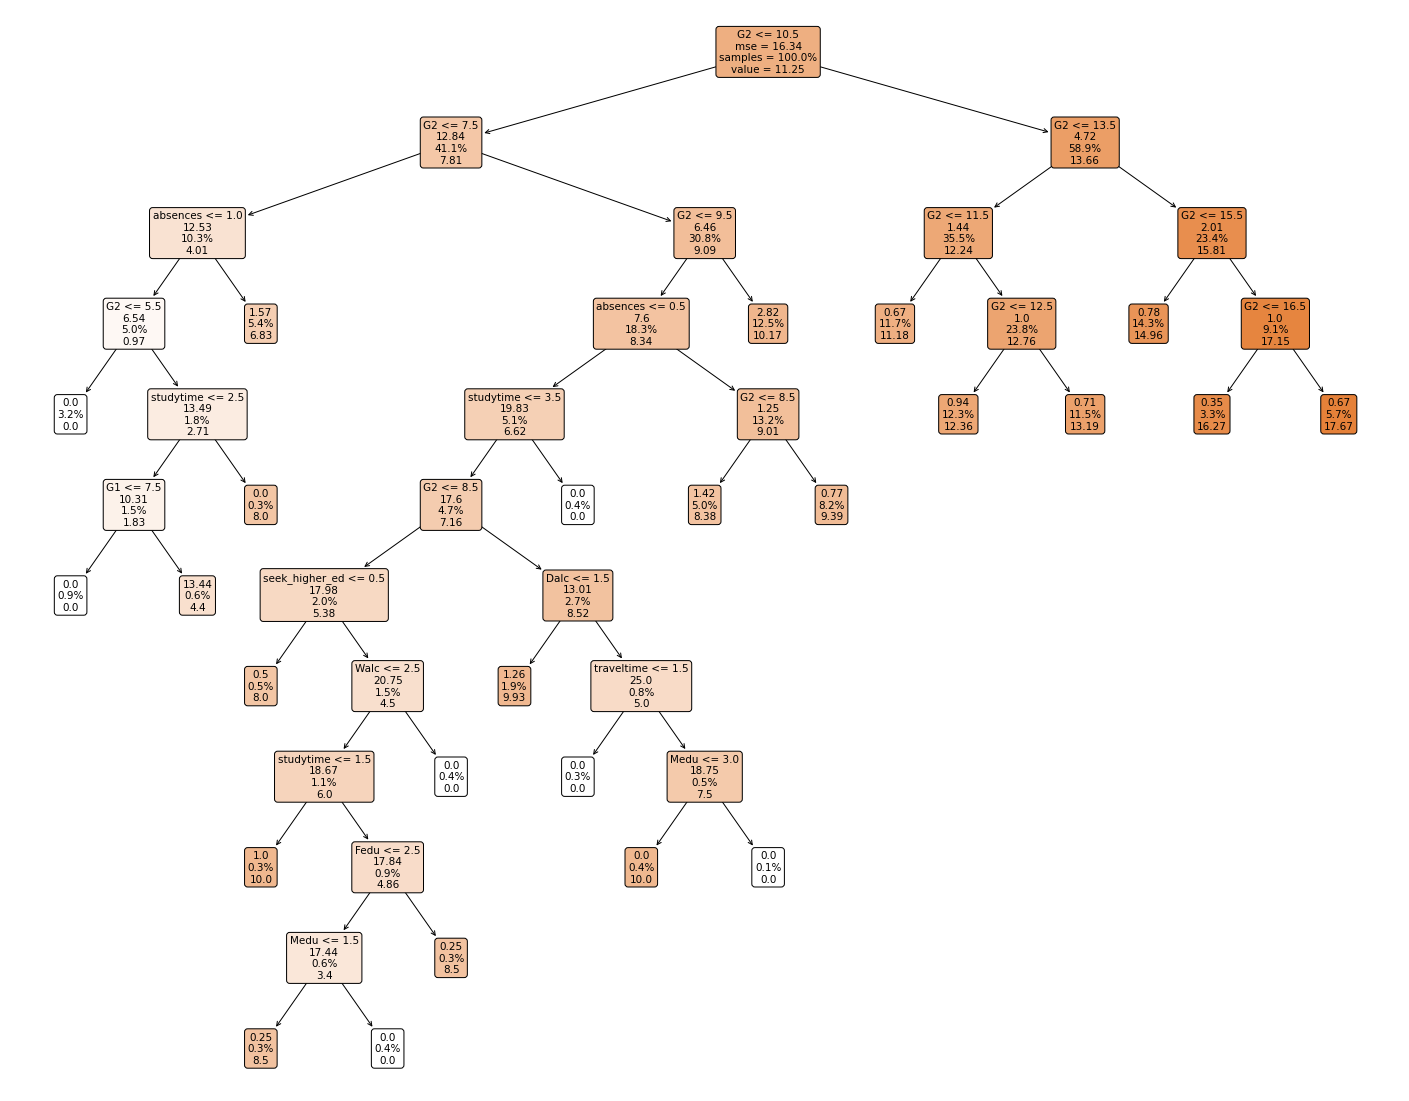

In [26]:
fig = plt.figure(figsize = (25, 20))
_ = tree.plot_tree(
    grade_model,
    feature_names = features,
    label = 'root',
    proportion = True,
    rounded = True,
    precision = 2,
    filled = True
)